# Regression (continuous case)

In [1]:
# let us import all the libraries
# to handle datasets
import numpy as np
import pandas as pd
# for plotting
import matplotlib.pyplot as plt
# to divide train and test set
from sklearn.model_selection import train_test_split
# feature scaling
from sklearn.preprocessing import MinMaxScaler
#to buid models
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
# models for Stacking
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
# to evaluate the model
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error,r2_score
import math
#to find training time of the model
import time
# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)
import warnings
warnings.simplefilter(action='ignore')

In [2]:
# load dataset
data = pd.read_csv('data/train.csv')

In [3]:
# Let's separate into train and test set
# Remember to set the seed (random_state for this sklearn function)
X_train, X_test, y_train, y_test = train_test_split(data,data['SalePrice'],test_size=0.25,
                                                     random_state=0) 
X_train.shape, X_test.shape

((1095, 81), (365, 81))

In [4]:
# replace missing values with mode
# make a list with the numerical variables that contain missing values
vars_with_na = [var for var in data.columns if X_train[var].isnull().sum() > 0 and X_train[var].dtypes != 'O']
for var in vars_with_na:
    # calculate the mode using the train set
    mode_val = X_train[var].mode()[0]
    # replace missing values by the mode
    # (in train and test)
    X_train[var] = X_train[var].fillna(mode_val)
    X_test[var] = X_test[var].fillna(mode_val)

# make a list of the categorical variables that contain missing values
vars_with_na = [var for var in data.columns if X_train[var].isnull().sum() > 0 and X_train[var].dtypes == 'O']
# replace missing values with new label: "Missing"
X_train[vars_with_na] = X_train[vars_with_na].fillna('Missing')
X_test[vars_with_na] = X_test[vars_with_na].fillna('Missing')

# let's capture the categorical variables in a list
cat_vars = [var for var in X_train.columns if X_train[var].dtype == 'O']
def find_frequent_labels(df, var, rare_perc):
    # find_frequent_labels function finds the labels that are shared by more than
    # a certain % of the houses in the dataset
    df = df.copy()
    tmp = df.groupby(var)['SalePrice'].count() / len(df)
    return tmp[tmp > rare_perc].index

for var in cat_vars:
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.01)
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(frequent_ls), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(frequent_ls), X_test[var], 'Rare')

def replace_categories(train, test, var, target):
    # order the categories in a variable from that with the lowest
    # house sale price, to that with the highest
    ordered_labels = train.groupby([var])[target].mean().sort_values().index
    # create a dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}

    # use the dictionary to replace the categorical strings by integers
    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)

for var in cat_vars:
    replace_categories(X_train, X_test, var, 'SalePrice')

def elapsed_years(df, var):
    # capture difference between the year variable
    # and the year in which the house was sold
    df[var] = df['YrSold'] - df[var]
    return df
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

for var in ['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice']:
    X_train[var] = np.log(X_train[var])
    X_test[var] = np.log(X_test[var])

# capture all variables in a list
# except the target and the ID
train_vars = [var for var in X_train.columns if var not in ['Id', 'SalePrice']]
# create scaler
scaler = MinMaxScaler()
#  fit  the scaler to the train set
scaler.fit(X_train[train_vars]) 
# transform the train and test set
X_train[train_vars] = scaler.transform(X_train[train_vars])
X_test[train_vars] = scaler.transform(X_test[train_vars])
print(X_train.isnull().sum().any(),X_test.isnull().sum().any())

False False


In [5]:
# capture the target (notice that the target is log transformed)
y_train = X_train['SalePrice']
y_test = X_test['SalePrice']
# drop unnecessary variables from our training and testing sets
X_train.drop(['Id', 'SalePrice'], axis=1, inplace=True)
X_test.drop(['Id', 'SalePrice'], axis=1, inplace=True)

sel_= SelectFromModel(Lasso(alpha=0.005,random_state=0))
# train Lasso model and select features
sel_.fit(X_train,y_train)

# let's print the number of total and selected features
selected_feats = X_train.columns[(sel_.get_support())]
# let's print some stats
print('Total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feats)))
print('features with coefficients shrank to zero: {}'.format(np.sum(sel_.estimator_.coef_== 0)))

Total features: 79
selected features: 25
features with coefficients shrank to zero: 54


In [6]:
# build model
X_train=X_train[selected_feats]
X_test=X_test[selected_feats]
# X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
# X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
print(X_train.shape,X_test.shape)

# The parameters inside the models can be varied 
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
GB_model= GradientBoostingRegressor(**params) 
lin_model = Lasso(alpha=0.005, random_state=0)
RF_model = RandomForestRegressor(n_estimators=400,random_state=0)
# Get these models in a list
estimators = [('Random Forest', RF_model),
              ('Lasso', lin_model),
              ('Gradient Boosting', GB_model)]
#Stack these models with StackingRegressor
stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())

(1095, 25) (365, 25)


In [11]:
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('True_Price')
    ax.set_ylabel('Predicted_Price')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + ' Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)

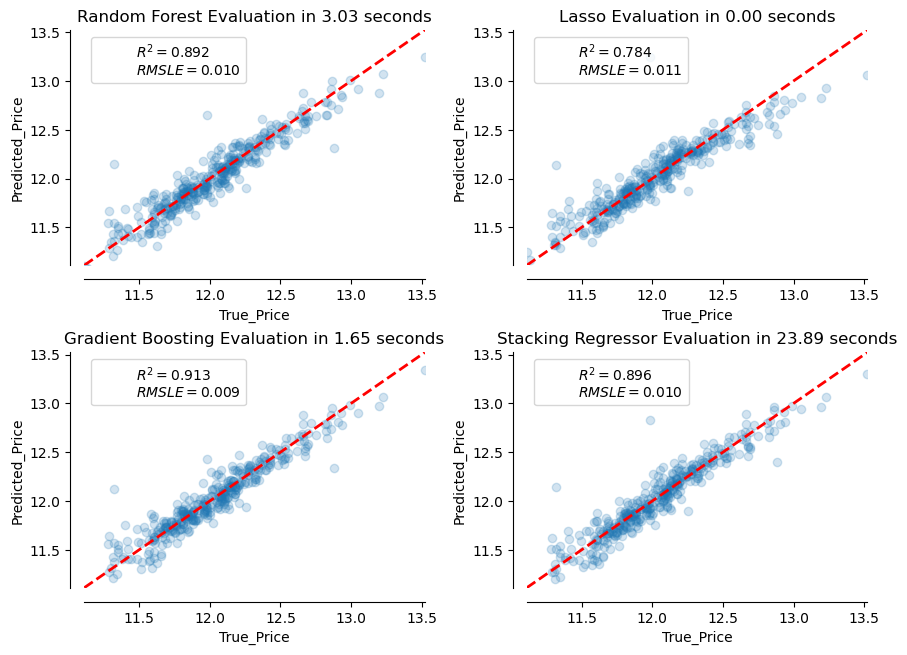

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)
errors_list=[]
for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                               stacking_regressor)]):
    start_time = time.time()
    
    model = est.fit(X_train, y_train)
                     
    elapsed_time = time.time() - start_time
    
    pred = model.predict(X_test)
    errors = y_test - model.predict(X_test)
    errors_list.append(errors)
    test_r2= r2_score(np.exp(y_test), np.exp(pred))
    
    test_rmsle=math.sqrt(mean_squared_log_error(y_test,pred))
    plot_regression_results(ax,y_test,pred,name,(r'$R^2={:.3f}$' + '\n' +
                            r'$RMSLE={:.3f}$').format(test_r2,test_rmsle),elapsed_time)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

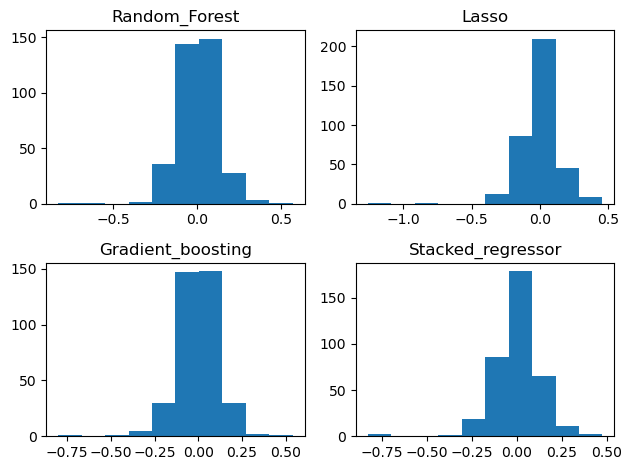

In [9]:
titles = ['Random_Forest','Lasso','Gradient_boosting','Stacked_regressor'] 
f,a = plt.subplots(2,2)
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(errors_list[idx])
    ax.set_title(titles[idx])
plt.tight_layout()

Text(0.5, 1.0, 'Feature Importance')

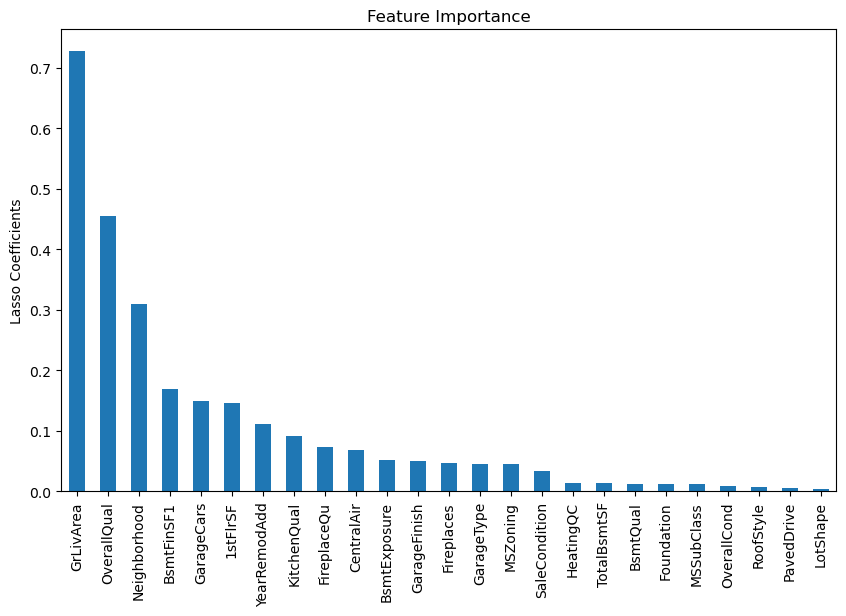

In [10]:
#let's look at the feature importance
importance = pd.Series(np.abs(lin_model.coef_.ravel()))
importance.index = selected_feats
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(10,6))
plt.ylabel('Lasso Coefficients')
plt.title('Feature Importance')

# Classifier (discrete case)

In [34]:
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import scikitplot as skplt

In [35]:
X, y = datasets.load_breast_cancer(return_X_y=True)

# Create Base Learners
base_learners = [
                 ('rf_1', RandomForestClassifier(n_estimators=10, random_state=42)),
                 ('rf_2', GradientBoostingClassifier() )             
                ]

# Initialize Stacking Classifier with the Meta Learner
clf = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())

# Extract score
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
#clf.fit(X_train, y_train).score(X_test, y_test)

model = clf.fit(X_train, y_train)
model_proba = model.predict_proba(X_test)
model_pred = np.where(model_proba[:,1] > 0.5, 1, 0)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

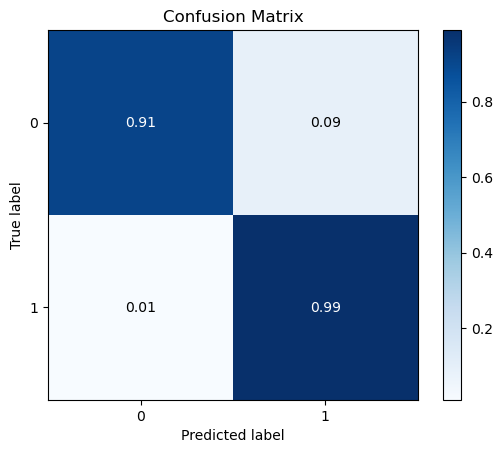

In [36]:
skplt.metrics.plot_confusion_matrix(y_test, model_pred, normalize=True, title = 'Confusion Matrix')